In [55]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [56]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# Design Generator and Dicriminator

In [57]:
class Generator(nn.Module):
    """docstring for Generator."""
    def __init__(self):
        super(Generator, self).__init__()
        self.d = 128
        self.linear1 = nn.Linear(100, self.d)
        self.linear2 = nn.Linear(self.d, self.d * 2)
        self.linear3 = nn.Linear(self.d * 2, self.d * 4)
        self.linear4 = nn.Linear(self.d * 4, 784)

    def forward(self, inputs):
        x = F.leaky_relu(self.linear1(inputs), 0.2)
        x = F.leaky_relu(self.linear2(x), 0.2)
        x = F.leaky_relu(self.linear3(x), 0.2)
        x = F.tanh(self.linear4(x))

        return x
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

class Discriminator(nn.Module):
    """docstring for Discriminator."""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.d = 128
        self.linear1 = nn.Linear(784, self.d * 4)
        self.linear2 = nn.Linear(self.d * 4, self.d * 2)
        self.linear3 = nn.Linear(self.d * 2, self.d)
        self.linear4 = nn.Linear(self.d, 1)

    # forward method
    def forward(self, inputs):
        x = F.leaky_relu(self.linear1(inputs), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.linear2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.linear3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.sigmoid(self.linear4(x))
        return x
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)




# Test Generator and Discriminator

In [58]:
z = torch.randn((128, 100))   # fixed noise
z = Variable(z, volatile=True)
generator_test = Generator()
z_conv = generator_test.forward(z)
print(z_conv.size())
plt.show()

torch.Size([128, 784])


In [59]:
discrimintaor_test = Discriminator()
pred_z_conv = discrimintaor_test(z_conv)
print(pred_z_conv.size())

torch.Size([128, 1])


# Load dataset

In [60]:
# MNIST dataset

#transform = transforms.Compose(
#    [torchvision.transforms.Resize((64, 64)),
#        transforms.ToTensor()],)

transform = transforms.Compose([
        #torchvision.transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.MNIST(root='./data',
                         train=True,
                         transform=transform,
                         download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

# Test on images

torch.Size([128, 1, 28, 28])


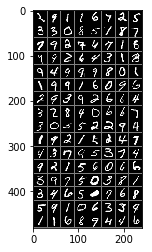

In [61]:
# get some random training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(images.size())
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()

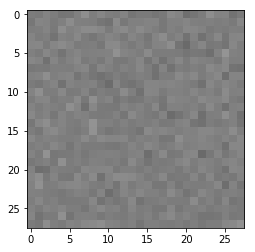

In [62]:
z = torch.randn((128, 100))   # fixed noise
z = Variable(z, volatile=True)
generator_test = Generator()
image = generator_test.forward(z)
img = image.cpu().data
imshow(torchvision.utils.make_grid(img[0].view(28,28)))
plt.show()

In [63]:
img = Variable(images)
print(img.size())
img = img.view(-1, 28*28)
pred_img_conv = discrimintaor_test(img)
print(pred_img_conv.size())

torch.Size([128, 1, 28, 28])
torch.Size([128, 1])


# Design model

In [64]:
def extract(v):
    return v.data.storage().tolist()
d_learning_rate = 0.00005
g_learning_rate = 0.00005
n_epoch = 100

In [65]:
#Define network
G = Generator()
D = Discriminator()
G.cuda()
D.cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

#Define Learning
d_optimizer = optim.RMSprop(D.parameters(), lr=d_learning_rate)
g_optimizer = optim.RMSprop(G.parameters(), lr=g_learning_rate)
G_loss = []
D_loss = []

n_critic = 5

# Training

In [66]:
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader):
        for _ in range(n_critic):
            D.zero_grad()

            #Compute gradient fake data
            img, _ = data
            batch_size = img.size()[0]
            real_data = Variable(img.cuda()).view(-1, 28*28)
            real_err = torch.mean(D(real_data))

            #compute grad fake data
            z = torch.randn(batch_size, 100)
            d_noise = Variable(z.cuda(), volatile = False) 
            fake_output = G(d_noise).detach()
            fake_err = torch.mean(D(fake_output))
            
            d_err = -(real_err - fake_err) #minimize the opposite function
            d_err.backward()
            d_optimizer.step()
            # Weight Clipping
            for param in D.parameters():
                param.data.clamp_(-0.01, 0.01)

        G.zero_grad()

        z = torch.randn(batch_size, 100)    # fixed noise
        g_noise = Variable(z.cuda())
        g_fake_data = G(g_noise)
        g_err = -torch.mean(D(g_fake_data))
        g_err.backward()
        g_optimizer.step()
        
        G_loss.append(extract(g_err)[0])
        D_loss.append(extract(real_err - fake_err)[0])



    print("%s: D: %s G: %s " % (epoch + 1,
                                        extract(real_err - fake_err)[0],
                                        extract(g_err)[0],
                                        ))

1: D: 0.23693880438804626 G: -0.5348365902900696 
2: D: 0.1542443037033081 G: -0.4800319969654083 
3: D: 0.14041292667388916 G: -0.5035203099250793 
4: D: 0.1148424744606018 G: -0.5293577313423157 
5: D: 0.1134217381477356 G: -0.5649312138557434 
6: D: 0.10477310419082642 G: -0.5607313513755798 
7: D: 0.1000891923904419 G: -0.5892118811607361 
8: D: 0.10584214329719543 G: -0.554618775844574 
9: D: 0.10891729593276978 G: -0.4702486991882324 
10: D: 0.10377904772758484 G: -0.49727630615234375 
11: D: 0.14519080519676208 G: -0.4575370252132416 
12: D: 0.13006964325904846 G: -0.43526753783226013 
13: D: 0.13489148020744324 G: -0.42389073967933655 
14: D: 0.16786283254623413 G: -0.3967644274234772 
15: D: 0.13798588514328003 G: -0.39682960510253906 
16: D: 0.15078988671302795 G: -0.3508133590221405 
17: D: 0.14442899823188782 G: -0.3799910843372345 
18: D: 0.13739529252052307 G: -0.4946499168872833 
19: D: 0.131931871175766 G: -0.39207568764686584 
20: D: 0.12175223231315613 G: -0.504492104

# Results

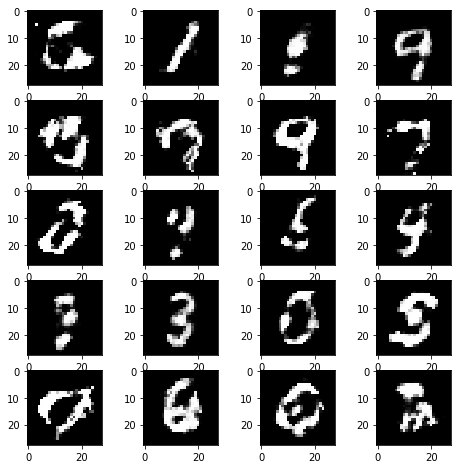

In [75]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = torch.randn((128, 100))    # fixed noise
    z = Variable(z.cuda(), volatile=True)
    images = G(z)
    img = images.cpu().data
    fig.add_subplot(rows, columns, i)
    imshow(torchvision.utils.make_grid(img[0].view(28,28)))
plt.show()
fig.savefig('WGAN_100epochs.png', bbox_inches='tight')

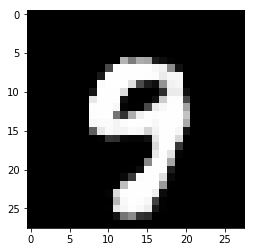

In [79]:
z = torch.randn((128, 100))    # fixed noise
z = Variable(z.cuda(), volatile=True)
images = G(z)
img = images.cpu().data
imshow(torchvision.utils.make_grid(img[0].view(28,28)))
plt.show()

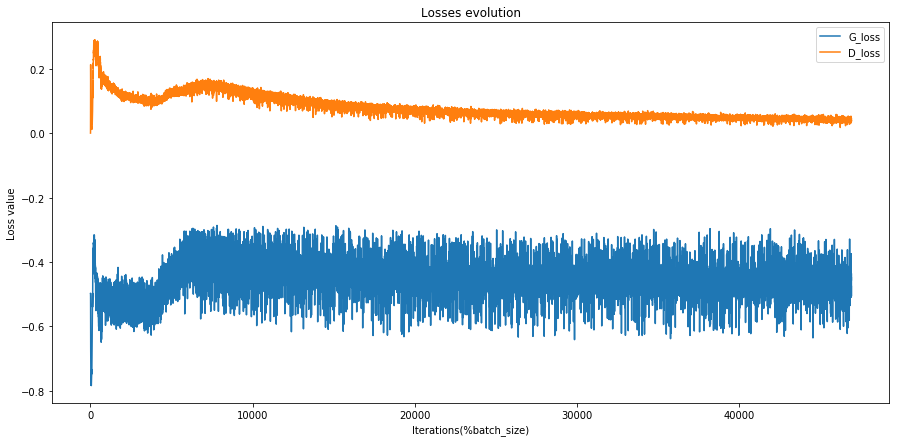

In [69]:
absc = np.linspace(0, len(G_loss), len(G_loss))
fig=plt.figure(figsize=(15, 7))
plt.plot(absc, G_loss, label = "G_loss")
plt.plot(absc, D_loss, label = "D_loss")
plt.title("Losses evolution")
plt.ylabel("Loss value")
plt.xlabel("Iterations(%batch_size)")
plt.legend()
plt.show()
fig.savefig('loss_WGAN_100epochs.png', bbox_inches='tight')